In [12]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=86c59927c1c139009c6a9f9b4b17f40599b715745e2a786be8790377435527bb
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime.lime_tabular
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplaine

In [22]:
X_train = pd.read_csv('/content/X_train_final.csv')
X_test = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [23]:
# Cleaning Column Names
for df in [X_train, X_test]:
    df.columns = df.columns.str.replace(r"[\[\]\(\),<]", "_", regex=True)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

In [24]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## XGBoost Classifier Model

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:35:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Evaluation
Accuracy: 0.94
Precision: 0.94
Recall: 0.96
F1 Score: 0.95
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       544
           1       0.94      0.96      0.95       635

    accuracy                           0.94      1179
   macro avg       0.94      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



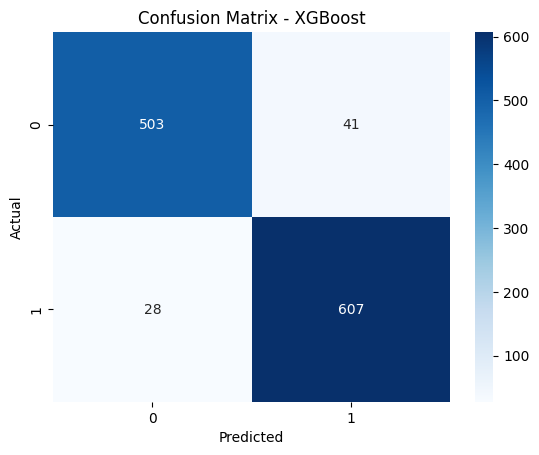

In [25]:
xgb_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_final.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_final, X_test, y_test)

### SHAP for XGBoost

SHAP Summary for XGBoost


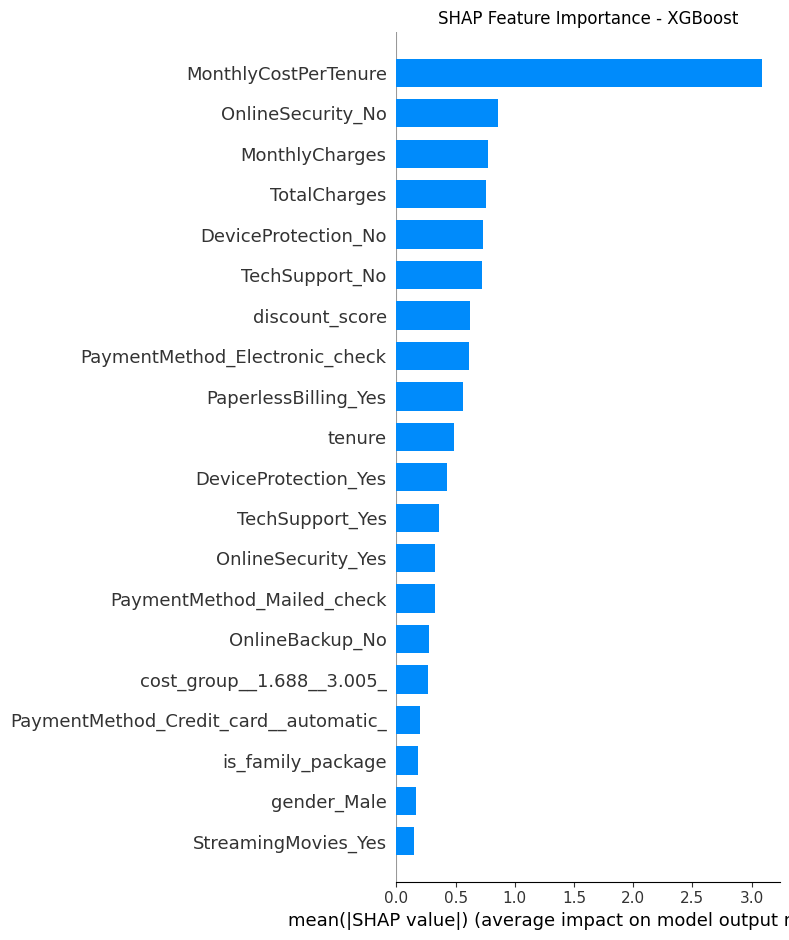

In [29]:
print("SHAP Summary for XGBoost")
explainer_xgb = shap.TreeExplainer(xgb_final)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

This SHAP bar plot highlights the most impactful features driving churn predictions:

* MonthlyCostPerTenure stands out as the most influential feature, indicating that customers who pay more per unit of tenure are at a higher risk of churn.

* Other strong contributors include:

    * OnlineSecurity_No and TechSupport_No, signaling that lack of support services increases churn risk.

    * Billing features like MonthlyCharges, TotalCharges, and PaymentMethod_Electronic check also play notable roles.

    * discount_score also shows moderate influence, suggesting that price sensitivity is important.

    * Features like tenure have lower importance here compared to Logistic Regression, likely because MonthlyCostPerTenure already captures tenure indirectly.

The XGBoost model focuses heavily on cost-related features and absence of value-added services to predict churn. This aligns with patterns seen across other models but emphasizes the compounded effect of cost efficiency (e.g., value for money) on customer retention.

### LIME for XGBoost

In [28]:
print("LIME Explanation for XGBoost")
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
explainer_lime = LimeTabularExplainer(X_train_df.values, feature_names=X_train_df.columns.tolist(), class_names=['No Churn', 'Churn'], discretize_continuous=True)
sample_instance = X_test_df.iloc[0]
exp = explainer_lime.explain_instance(sample_instance.values, xgb_final.predict_proba)
exp.show_in_notebook()

LIME Explanation for XGBoost


This LIME explanation provides a local interpretation of a single churn prediction:

* The model predicts 84% probability of churn for this customer.

* The top positive contributors (increasing churn likelihood) include:

    * High MonthlyCostPerTenure (43.80) — strong impact (+0.41)

    * No Online Security and No Device Protection — both increase churn risk due to absence of protective services

    * No Tech Support and Electronic Check payment method — also contribute positively toward churn.

* On the other hand, features that reduce churn probability include:

  * Having TechSupport_Yes, PaperlessBilling_Yes, and Credit card (automatic) payment — often associated with satisfied or long-term customers.

This LIME output confirms the global SHAP insight: cost-effectiveness and service availability are key churn drivers. This customer pays a lot early (high MonthlyCostPerTenure) and lacks security/support services, which the model strongly associates with higher churn risk.


### PDP for XGBoost

In [33]:
pdp_feature = 'MonthlyCostPerTenure'
feature_index = list(X_train.columns).index(pdp_feature)

PDP - XGBoost


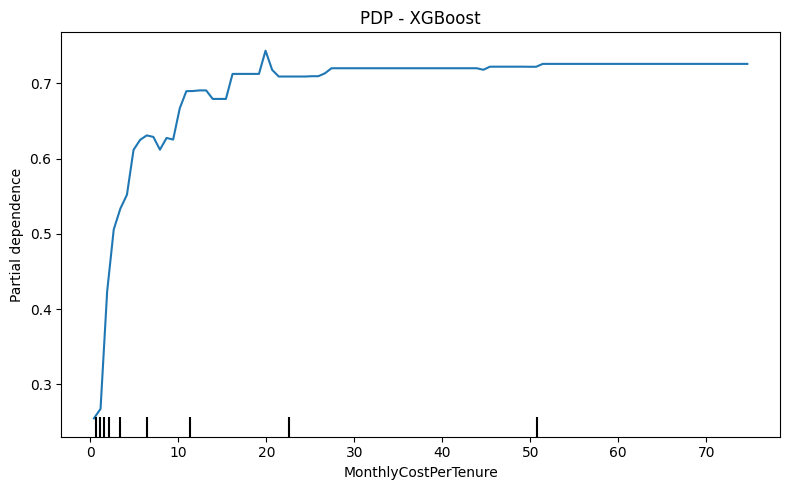

In [37]:
print("PDP - XGBoost")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(xgb_final, X_test, [feature_index], feature_names=X_train.columns, ax=ax)
ax.set_title("PDP - XGBoost")
plt.tight_layout()
plt.show()

This Partial Dependence Plot shows how the feature MonthlyCostPerTenure impacts churn predictions:

* The PDP indicates that as MonthlyCostPerTenure increases, the probability of churn increases sharply at first and then plateaus around a high value (~0.72).

* This suggests that customers who pay a high monthly charge relative to their tenure are much more likely to churn.

* After a certain threshold (~20 units), the model predicts consistently high churn risk, meaning that the risk stabilizes for extremely high values.

MonthlyCostPerTenure is a strong churn predictor in the XGBoost model. Customers paying disproportionately more than others early in their subscription are highly likely to churn.

### ICE for XGBoost

ICE - XGBoost


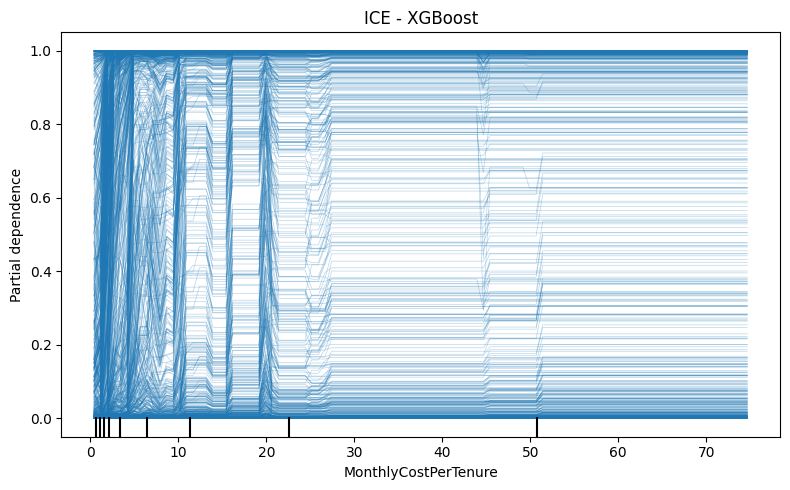

In [38]:
print("ICE - XGBoost")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(xgb_final, X_test, [feature_index], feature_names=X_train.columns, kind='individual', ax=ax)
ax.set_title("ICE - XGBoost")
plt.tight_layout()
plt.show()

This ICE plot shows the individual effects of the MonthlyCostPerTenure feature on predicted churn probability:

* Each blue line represents how churn probability changes for a specific customer as their MonthlyCostPerTenure varies.

* The majority of lines slope upward quickly and then flatten, indicating that higher costs relative to tenure sharply increase churn risk, especially in the lower ranges.

* After ~20 units, most lines reach high churn probability (close to 1.0), confirming a strong and consistent influence.

MonthlyCostPerTenure has a strong and consistent positive effect on churn predictions across most customers in the XGBoost model. This reinforces the feature’s critical role in model behavior and decision-making.